## FA24 ECE 225A Final Project -- MNIST Identifier
### By Henry Lin & Henry Liu

## Introduction

## Setup

#### Library Imports

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree
import time

#### MNIST Data
MNIST is a dataset of 70,000 grayscale images of handwritten digits (0-9), commonly used for training and testing machine learning models in image classification tasks. It consists of 60,000 training images and 10,000 testing images, each sized 28x28 pixels.

In [2]:
(train_data, train_labels), (test_data, test_labels) = (
    tf.keras.datasets.mnist.load_data()
)

# create a validation set that is the same size as the test set
validation_size = len(test_data)
validation_data = train_data[-validation_size:]
validation_labels = train_labels[-validation_size:]

train_data = train_data[:-validation_size]
train_labels = train_labels[:-validation_size]

train_data = train_data.reshape(len(train_data), 784)
validation_data= validation_data.reshape(len(validation_data),784)
test_data = test_data.reshape(len(test_data),784)

print("Training dataset dimensions:", np.shape(train_data))
print("Training labels dimensions:", np.shape(train_labels))
print("Validation dataset dimensions:", np.shape(validation_data))
print("Validation labels dimensions:", np.shape(validation_labels))
print("Test dataset dimensions:", np.shape(test_data))
print("Test labels dimensions", np.shape(test_labels))

Training dataset dimensions: (50000, 784)
Training labels dimensions: (50000,)
Validation dataset dimensions: (10000, 784)
Validation labels dimensions: (10000,)
Test dataset dimensions: (10000, 784)
Test labels dimensions (10000,)


## K-Nearest Neighbors

#### Euclidean Distance
A common method to measure the distance between two points is Euclidean distance, which calculates the straight-line distance in a multi-dimensional space. In the case of MNIST, each image is represented as a point in a 784-dimensional space (28x28 pixels).

So for two vectors $x, y \in \mathbb{R}^{784}$, their Euclidean distance is defined as: 
$$\|x - y\| = \sqrt{\sum_{i=1}^{784} (x_i - y_i)^2}$$

In [3]:
def euclidean_distance(v1, v2):
    """
    For two vectors v1 and v2, return the Euclidean distance between the two vectors.
    """
    return np.linalg.norm(v1 - v2)

#### Computing K-Nearest Neighbors
Use the `euclidean_distance` function to compute the indices of the n nearest neighbor in `train_data`.

In [4]:
def find_k_nearest_neighbors(x, k):
    """
    For a given point x, compute the indices of the k nearest neighbors in the training dataset
    and return these indices in a list.
    """
    distances = [
        euclidean_distance(x, train_data_point) for train_data_point in train_data
    ]
    sorted_indices = np.argsort(distances)
    k_indices = sorted_indices[:k]
    return k_indices

In [5]:
def classify_point(x, k):
    """
    Classifies a given point x based on the labels of its k-nearest neighbors in the training dataset.
    """
    nearest_neighbors = find_k_nearest_neighbors(x, k)
    k_labels = [train_labels[neighbor_idx] for neighbor_idx in nearest_neighbors]
    unique_labels, counts = np.unique(k_labels, return_counts=True)
    max_count_idx = np.argmax(counts)

    return unique_labels[max_count_idx]

In [6]:
t1 = time.time()
predicted_label = classify_point(test_data[0], 5)
t2 = time.time()
print("The predicted label of the test data point is", predicted_label)
print("The actual label of the test data point is", test_labels[0])
print("Taking", t2 - t1, "seconds to classify")

The predicted label of the test data point is 7
The actual label of the test data point is 7
Taking 0.14012503623962402 seconds to classify


#### Optimized K-Nearest Neighbors
We can optimize the classification time of a given point using Scikit-learn's BallTree.

In [7]:
ball_tree = BallTree(train_data)


def optimized_classify_point(x, k):
    """
    Classifies a given point x based on the labels of its k-nearest neighbors in the training dataset using BallTree.
    """
    neighbors_idx = np.squeeze(
        ball_tree.query(x.reshape(1, -1), k=k, return_distance=False)
    )
    ball_tree_predictions = train_labels[neighbors_idx]
    unique_labels, counts = np.unique(ball_tree_predictions, return_counts=True)
    max_count_idx = np.argmax(counts)

    return unique_labels[max_count_idx]

In [8]:
t1 = time.time()
predicted_label = optimized_classify_point(test_data[0], 5)
t2 = time.time()
print("The predicted label of the test data point is", predicted_label)
print("The actual label of the test data point is", test_labels[0])
print("Taking", t2-t1,"seconds to classify")

The predicted label of the test data point is 7
The actual label of the test data point is 7
Taking 0.038507938385009766 seconds to classify


#### Parameter Tuning
Utilize the validation dataset to determine the optimal value of `k` for classifying points, aiming to achieve the highest accuracy.

Test for values of `k` where `k` $\in \{1,3,5,7,9,10,15,20\}$.

In [9]:
k_candidates = [1, 3, 5, 7, 9, 10, 15, 20]
accuracy_for_k_val = {}

for k in k_candidates:
    neighbors_idx = np.squeeze(
        ball_tree.query(validation_data, k=k, return_distance=False)
    )

    ball_tree_predictions = train_labels[neighbors_idx]

    predicted_labels = []
    for prediction in ball_tree_predictions:
        unique_labels, counts = np.unique(prediction, return_counts=True)
        max_count_idx = np.argmax(counts)
        predicted_labels.append(unique_labels[max_count_idx])

    correct_predictions = np.sum(predicted_labels == validation_labels)
    accuracy = correct_predictions / len(validation_labels)
    accuracy_for_k_val[k] = accuracy

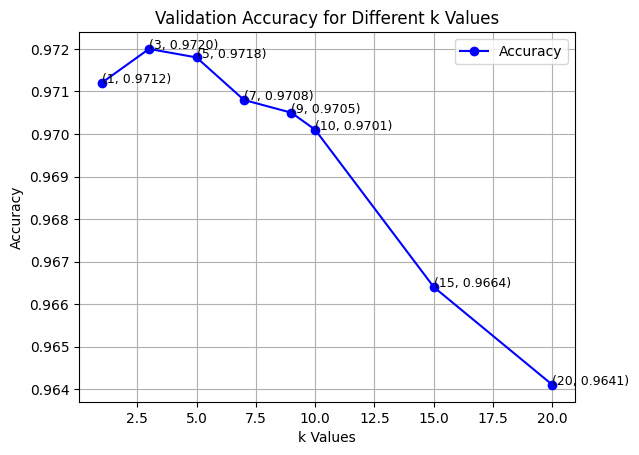

In [10]:
k_values = list(accuracy_for_k_val.keys())
accuracies = list(accuracy_for_k_val.values())

plt.figure()
plt.plot(k_values, accuracies, marker="o", linestyle="-", color="b", label="Accuracy")

plt.xlabel("k Values")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy for Different k Values")
plt.legend()

for i, (k, accuracy) in enumerate(zip(k_values, accuracies)):
    plt.text(
        k, accuracy, f"({k}, {accuracy:.4f})", fontsize=9, ha="left", color="black"
    )

plt.grid(True)
plt.show()

`k` = 3 yields the highest accuracy on the validation set.

#### Test Error
From the validation set, we found that the optimal `k` value is 3. We will now evaluate its performance by testing the error rate on the test dataset.

In [11]:
neighbors_idx = np.squeeze(ball_tree.query(test_data, k=3, return_distance=False))

ball_tree_predictions = train_labels[neighbors_idx]

predicted_labels = []
for prediction in ball_tree_predictions:
    unique_labels, counts = np.unique(prediction, return_counts=True)
    max_count_idx = np.argmax(counts)
    predicted_labels.append(unique_labels[max_count_idx])

correct_predictions = np.sum(predicted_labels == test_labels)
accuracy = correct_predictions / len(test_labels)

print("Accuracy for k=3:", accuracy)

Accuracy for k=3: 0.9681
